# Seabird Watch

All data in this notebook is obtained from the Citizen Science project [SeaBird Watch](https://www.zooniverse.org/projects/penguintom79/seabirdwatch). Here, I conduct a basic exploration into this data, to charegorise it and test image visualisation and annotation before embarking in neural neotwork implementations.

## Example Data

In [1]:
# Relevant imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import birdspy as bs

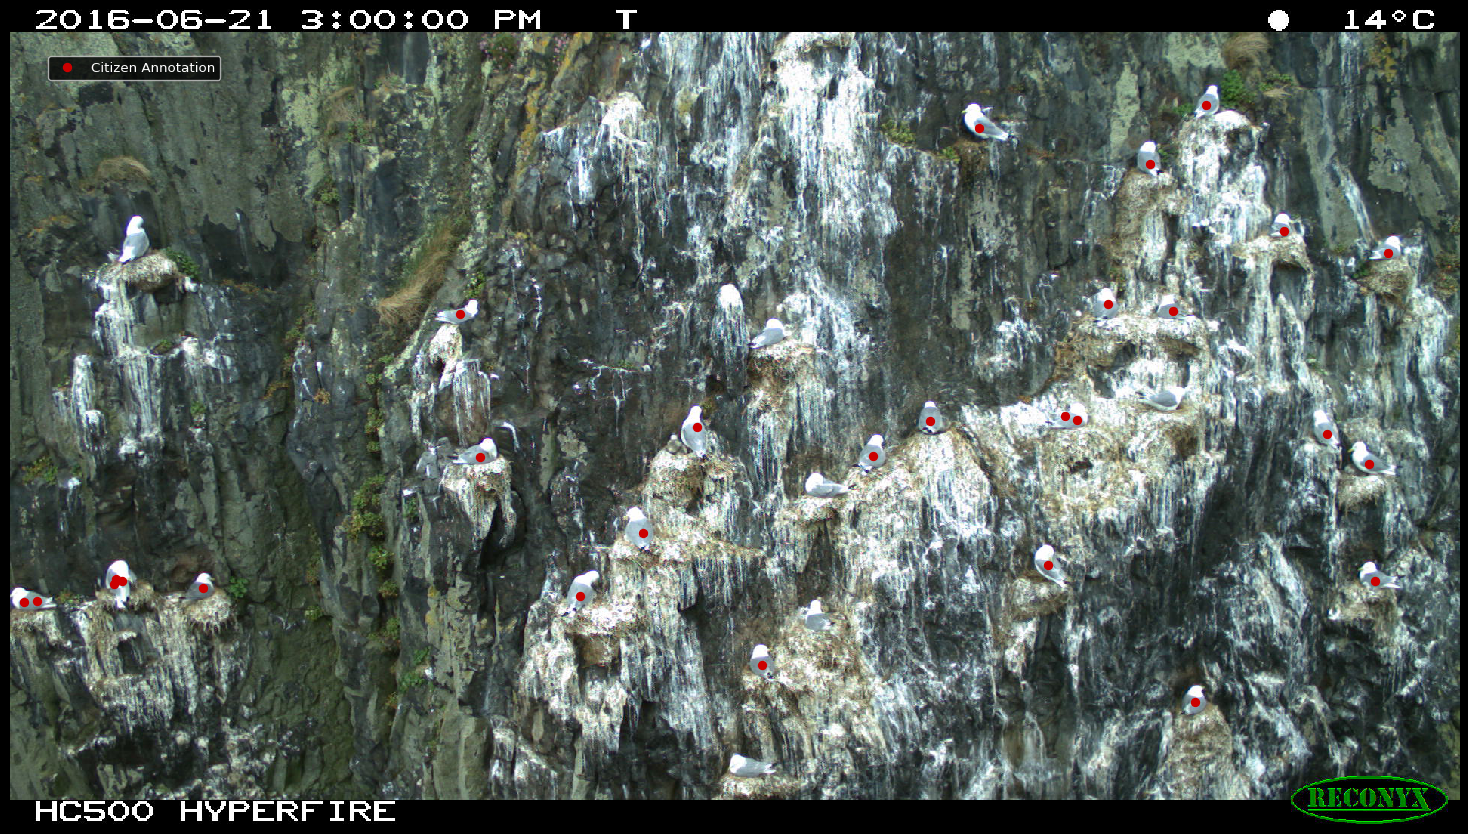

In [2]:
# Plot example image from database

im = bs.BirdImage("images/HVITa_renamed/HVITa2016a_renamed/HVITa2016a_000001.JPG")
im.get_annotations()
im.save("figures/example_image.jpg")
im.print(citizen_annotations=True)

## Annotation Metadata

Annotation data is collected from the citizen science platform, and processed following the methods used in [Jones et al. 2018](https://doi.org/10.1038/sdata.2018.124). In summary, at least ten users will classify every image, whose raw clicks are combined to give one ‘consensus’ click per bird, in the form of x and y pixel values in the originial size image. The number of raw clicks that each consensus click is formed from is recorded for each image, and it is worth looking at the distribution of these.

In [3]:
# Number of people who have considered each image
# Compare to number who have indicated they have marked all birds in each image
file_path = "annotations/HVITa_citsciConsensus_kadult.csv"
df = pd.read_csv(file_path)

df_img = df.drop_duplicates(subset='image_id', keep="last")
print(f"There are annotations for {len(df_img.index)} images in the dataset")

There are annotations for 3498 images in the dataset


Text(0, 0.5, 'Frequency')

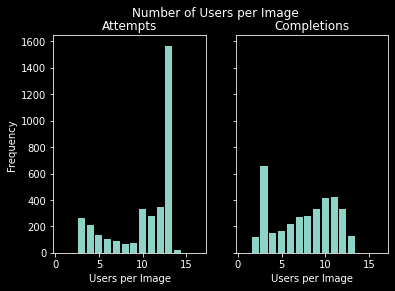

In [4]:
c_labels, c_counts = np.unique(df_img["classifications"], return_counts=True)
m_labels, m_counts = np.unique(df_img["markedall_num_votes"], return_counts=True)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].bar(c_labels, c_counts, align='center')
axs[0].title.set_text('Attempts')
axs[1].bar(m_labels, m_counts, align='center')
axs[1].title.set_text('Completions')
fig.suptitle("Number of Users per Image")
axs[0].set_xlabel("Users per Image"), axs[1].set_xlabel("Users per Image")
axs[0].set_ylabel("Frequency")

There are a lot of images here that have been viewed by fewer than ten users (the target provided by the researchers)! However, many of these have no clusters marked (with 'NA' in the cluster columns) so we can exclude these (both from the bar chart and our later analysis).

We have removed 1924 images with no annotations from the dataset


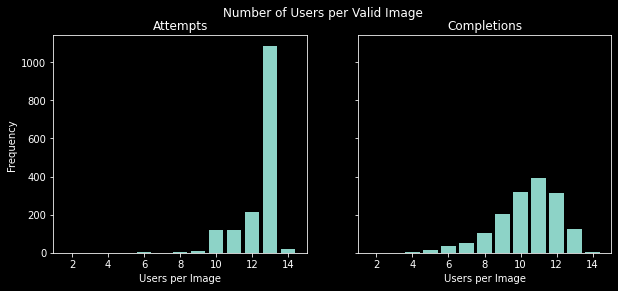

In [5]:
# Exclude images that have no clusters
df_valid_img = df_img.drop(df_img.index[np.isnan(df_img["num_markings"])], inplace=False)
print(f"We have removed {len(df_img.index) - len(df_valid_img.index)} images with no annotations from the dataset")

c_labels, c_counts = np.unique(df_valid_img["classifications"], return_counts=True)
m_labels, m_counts = np.unique(df_valid_img["markedall_num_votes"], return_counts=True)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (10, 4))
axs[0].bar(c_labels, c_counts, align='center')
axs[0].title.set_text('Attempts')
axs[1].bar(m_labels, m_counts, align='center')
axs[1].title.set_text('Completions')
fig.suptitle("Number of Users per Valid Image")
axs[0].set_xlabel("Users per Image"), axs[1].set_xlabel("Users per Image")
axs[0].set_ylabel("Frequency")
plt.savefig("figures/annotation_metadata/users_per_img.png")

There is now a negligible number of images which have been viewed less than ten times, although not all of those ten users will have indicated that they have clicked all the birds. We may consider how many times each bird is clicked:

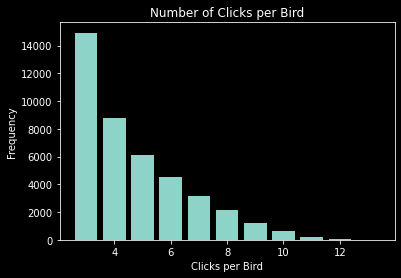

In [6]:
# Histogram of number of raw clicks per bird

labels, counts = np.unique(df["num_markings"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.title("Number of Clicks per Bird")
plt.xlabel("Clicks per Bird"), plt.ylabel("Frequency")
plt.savefig("figures/annotation_metadata/clicks_per_birds.png")



Give that a minimum of 10 people view each image, clearly they are not consistently picking up all birds in the photo. It would be interesting to see if this data is better for users who do believe they've clicked all birds in the photo, although this would require changes to the preproccessing algorithm that produced this csv, so is not possible here.

## Annotation Accuracy

We may also consider the accuracy of citizen data to gold standard data provided by a researcher. An example of such annotation data is given below (and clearly picks up more of the birds than the citizen data without double counting). 

Can we compare number of birds in each image to the gold standard data, plotting a histogram of the errors?

In [7]:
def count_birds_per_img(df, counts_name = 'Counts'):
    """Count number of birds in image, return dataframe with one row per valid image"""
    df_out = df.drop(df.index[np.isnan(df["cluster_x"])], inplace=False)  # remove empty images
    df_out[counts_name] = df_out['image_id'].map(df_out['image_id'].value_counts())
    df_out.drop_duplicates(subset='image_id', keep="last", inplace=True)
    return df_out

file_path = "annotations/HVITa_goldstandard_kadult.csv"
df_gold = pd.read_csv(file_path)

df_cit = count_birds_per_img(df, "Count_cit")
df_gold = count_birds_per_img(df_gold, "Count_gold")
df_cit_overlap = df_cit.drop(df_cit.index[~df_cit["image_id"].isin(df_gold["image_id"])])


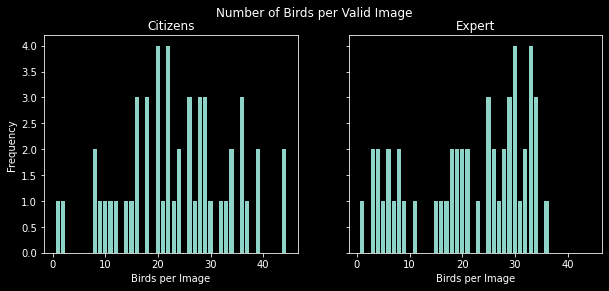

In [8]:
# Only the 2016a and 2016b datasets have gold annotations, and only some images within these
# So iterate over all gold standard images and check for a citizen equivalent

df_comb = df_cit.merge(df_gold, how='right', on='image_id')  # Keep only keys from gold dataframe
df_comb = df_comb.drop(df_comb.index[np.isnan(df_comb[["Count_cit", "Count_gold"]]).any(axis=1)], inplace=False)  # remove empty images

c_labels, c_counts = np.unique(df_comb["Count_cit"], return_counts=True)
g_labels, g_counts = np.unique(df_comb["Count_gold"], return_counts=True)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))
axs[0].bar(c_labels, c_counts, align='center')
axs[0].title.set_text('Citizens')
axs[1].bar(g_labels, g_counts, align='center')
axs[1].title.set_text('Expert')
fig.suptitle("Number of Birds per Valid Image")
axs[0].set_xlabel("Birds per Image"), axs[1].set_xlabel("Birds per Image")
axs[0].set_ylabel("Frequency")
plt.savefig("figures/annotation_metadata/birds_per_image.png")

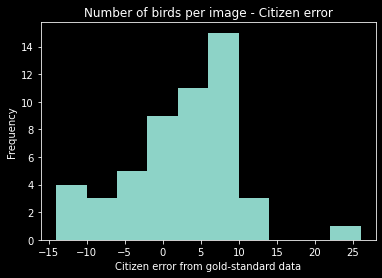

In [9]:
df_comb['Count_err'] = df_comb['Count_cit'] - df_comb['Count_gold']
df_comb['Count_err'].plot.hist()
plt.title("Number of birds per image - Citizen error")
plt.xlabel("Citizen error from gold-standard data");
plt.savefig("figures/annotation_metadata/citizen_error.png")

In [10]:
print(df_comb[["image_id", "Count_cit", "Count_gold", "Count_err"]])

                 image_id  Count_cit  Count_gold  Count_err
0   HVITa2016a_000007.JPG       30.0          28        2.0
1   HVITa2016a_000015.JPG       32.0          30        2.0
2   HVITa2016a_000023.JPG       36.0          30        6.0
3   HVITa2016a_000031.JPG       28.0          34       -6.0
4   HVITa2016a_000039.JPG       36.0          29        7.0
5   HVITa2016a_000047.JPG       20.0          34      -14.0
6   HVITa2016a_000055.JPG       34.0          29        5.0
7   HVITa2016a_000063.JPG       29.0          34       -5.0
8   HVITa2016a_000071.JPG       33.0          32        1.0
9   HVITa2016a_000079.JPG       39.0          30        9.0
10  HVITa2016a_000087.JPG       22.0          33      -11.0
11  HVITa2016a_000095.JPG       26.0          36      -10.0
12  HVITa2016a_000103.JPG       37.0          32        5.0
13  HVITa2016a_000111.JPG       26.0          33       -7.0
14  HVITa2016a_000119.JPG       22.0          33      -11.0
15  HVITa2016a_000127.JPG       44.0    

## Examples of Over- and Under- counting

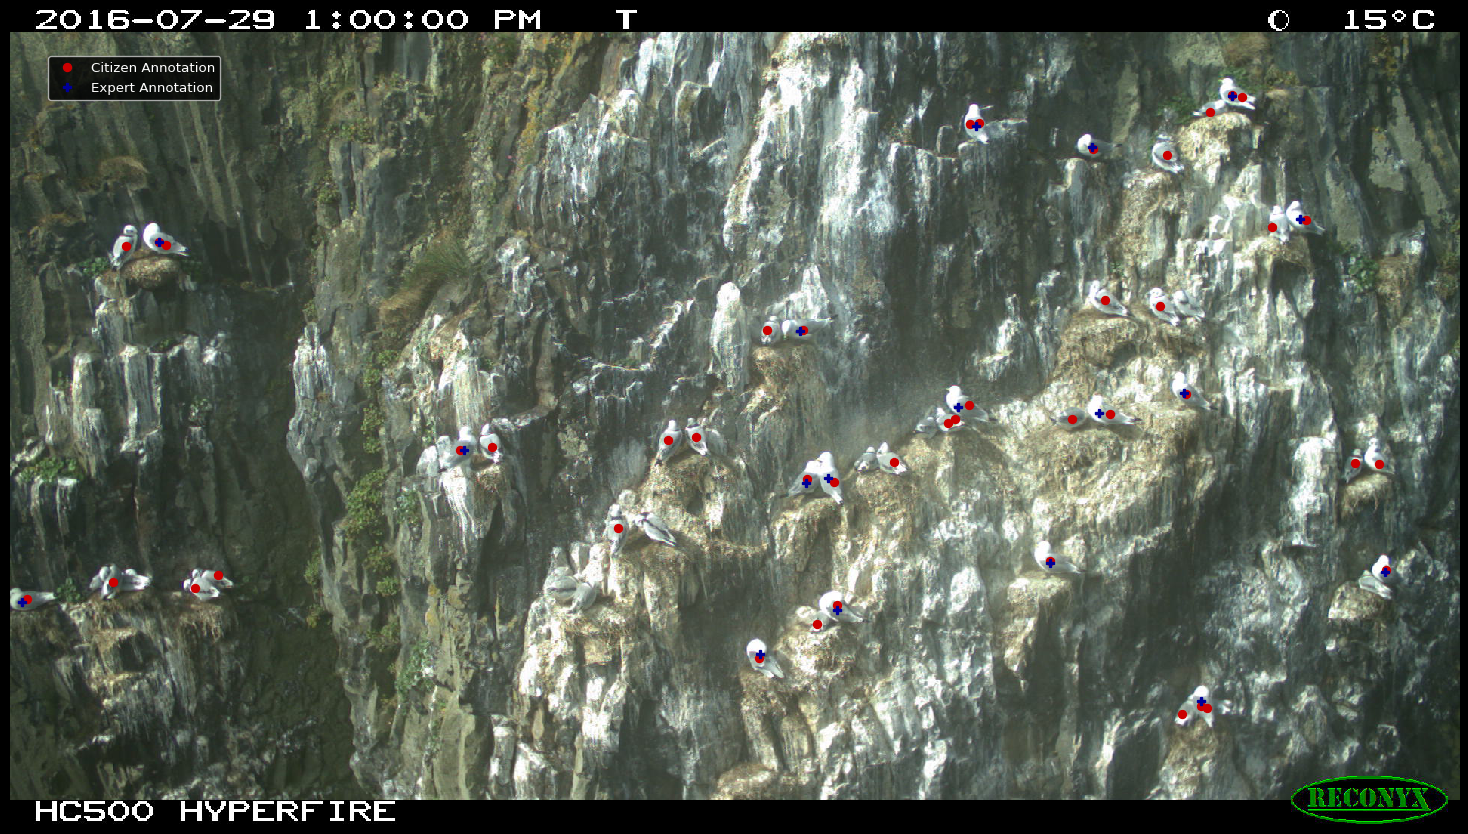

In [11]:
# Overcounting (HVITa2016b_000030.JPG)

im = bs.BirdImage("images/HVITa_renamed/HVITa2016b_renamed/HVITa2016b_000030.JPG")
im.get_annotations()
im.print(save_loc = "figures/example_overcounting.jpg",
         citizen_annotations = True, gold_annotations=True)

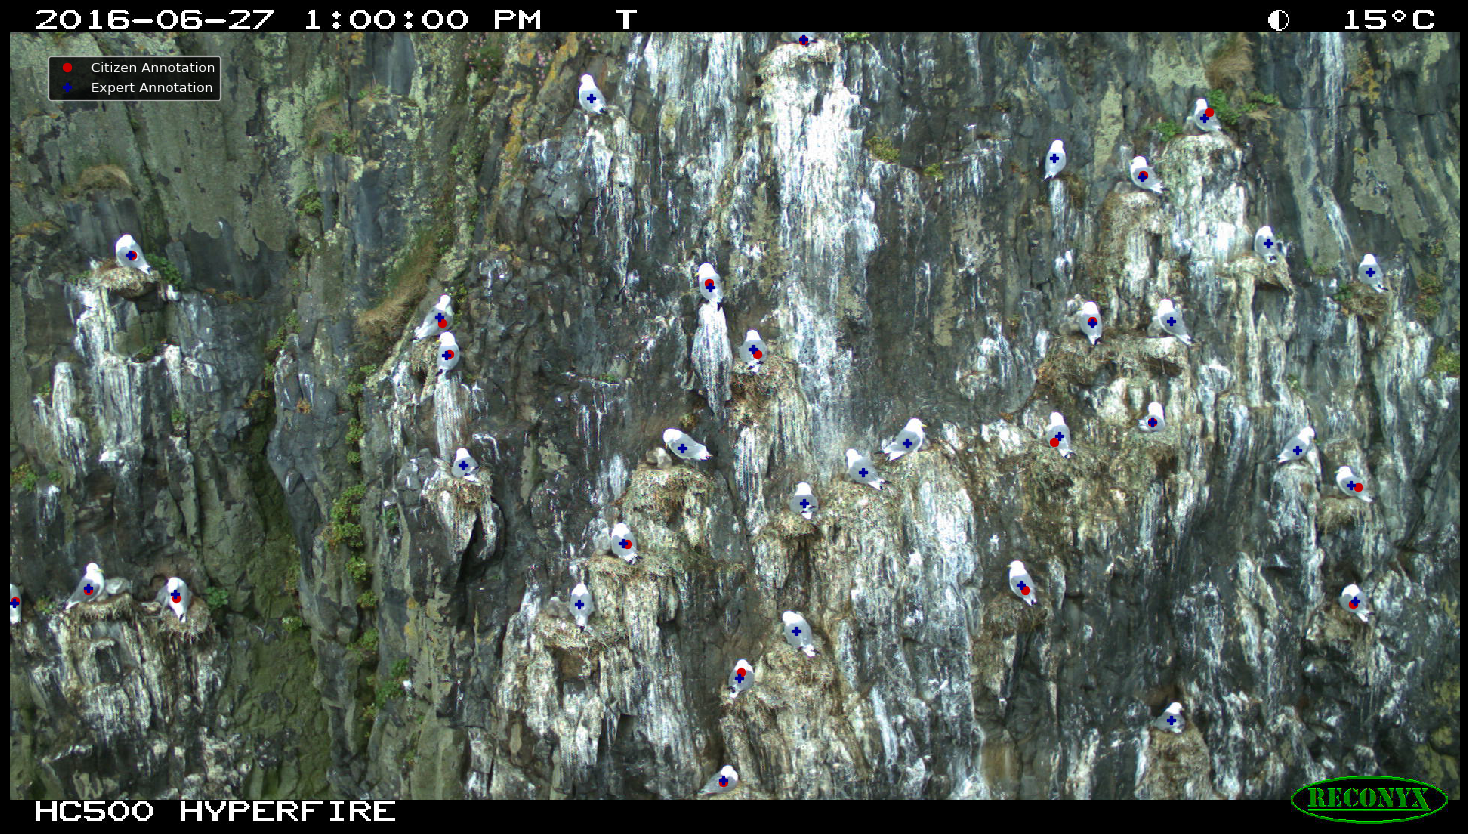

In [12]:
# Undercounting (HVITa2016a_000047.JPG)

im = bs.BirdImage("images/HVITa_renamed/HVITa2016a_renamed/HVITa2016a_000047.JPG")
im.get_annotations()
im.print(save_loc = "figures/example_undercounting.jpg",
         citizen_annotations = True, gold_annotations=True)

From this analysis, I believe the undercounting is indeed a result of citizens missing some birds, as might have been expected. More interestingly, the overcounting is not (in this example) a result of double counting birds, but rather counting juvinile birds, which are not inlcuded by the expert.

Note that overcounting is hard to avoid in this method of preprocessing - while having a minimum of 10 users considering each image reduces the likelihood of birds being missed, it increases the chance of a 3+ individuals mis-identifying a bird (i.e. identifying a juvenile as an adult in this case, although it could happen with other bird species, or even avian-like natural features).